In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as d
import matplotlib.pyplot as plt

In [5]:
#Parameters
samplenum = 400
epochs = 200
minibatch_size= 50
hiddenlayers = [140, 90]
input_size = 3
output_size = 3
learning_rate = 0.001
time_length = 30; #seconds

In [6]:
# Generate simulation
dyn = d.PyDyn('Data/point-mass_pendulum.sim', time_length)
#dyn = d.PyDyn('Data/rb-pendulum/twoRb.sim', time_length)
state_init = dyn.compute(dyn.p_init)
f = dyn.f(state_init, dyn.p_init)
df = dyn.df_dp(state_init, dyn.p_init)
dy = dyn.dy_dp(state_init, dyn.p_init)

In [7]:
#Sample targets only variables in z direction
y_target = np.zeros((samplenum,3))
y_target[:,2] = np.random.rand(samplenum)/2
y_target[:,1] = 2
y_target= torch.tensor(y_target)

## Building the custon Simulation activation function and model

In [8]:
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        p = input.clone().numpy().transpose()
        state = dyn.compute(p)
        y_pred = torch.tensor(state.y[-3:])
        
        ctx.save_for_backward(input)
        
        return y_pred
    
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output.shape)
        input, = ctx.saved_tensors
        p = input.clone().numpy().transpose()
        state= dyn.compute(p)
        dy_dp = dyn.dy_dp(state, p)
        dy_dp = dy_dp[-3:, :]
        grad_output = grad_output.unsqueeze(0)
        
        grad_input = torch.tensor(dy_dp).t().mm(grad_output.t()).t()
        return grad_input

Simulate = Simulate.apply

class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        #self.H1 = nn.Linear(hiddenlayers[0], 3*time_length)
        self.H1 = nn.Linear(hiddenlayers[0], hiddenlayers[1])
        self.H2 = nn.Linear(hiddenlayers[1], 3*time_length)
        self.P = nn.Linear(3*time_length, 3*time_length)
        self.Relu = nn.ReLU(inplace=True)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.H2(x)
        #x = self.Relu(x)
        x = self.P(x)
        return x


model = ActiveLearn(input_size, output_size)

criterion = nn.MSELoss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

y_target = y_target.float()

## Train the model

In [9]:
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p start condition
weight_c2 = 1 # p smoothness condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        for i in range(minibatch_size-1):
            y_i = y_target[b*minibatch_size+i,:]
            p_i = model(y_i)
            y_pred = Simulate(p_i)
            smoothness_error_i = weight_c2*(p_i[0:3*(time_length-1)] - p_i[3:3*time_length]).pow(2).sum()
            #smoothness_error_i = weight_c2*torch.sqrt(criterion(p_i[0:3*(time_length-1)], p_i[3:3*time_length]))
            #p_start_error = weight_c1*torch.sqrt(criterion(p_i[0:3].double(), torch.tensor(dyn.p_init[0:3])))
            p_start_error = weight_c1*criterion(p_i[0:3].double(), torch.tensor(dyn.p_init[0:3]))
            #y_end_error = torch.sqrt(criterion(y_pred.float(), y_i))
            y_end_error = criterion(y_pred.float(), y_i)
            loss_i = y_end_error + p_start_error + smoothness_error_i
            loss_batch = loss_batch + loss_i
            smoothness_error_batch = smoothness_error_batch + smoothness_error_i
        loss = loss_batch/minibatch_size
        losses.append(loss)
        smoothness_error = smoothness_error_batch/minibatch_size
        smoothness_errors.append(smoothness_error)
        basic_error = loss - smoothness_error
        basic_errors.append(basic_error)
        optimizer.zero_grad()
        #Back Prop
        loss.backward()
        optimizer.step()
    print(f'epoch: {e:3}/{epochs}    loss: {loss.item():10.4f}    smoothness error: {smoothness_error.item():10.4f}   basic error: {basic_error.item():10.4f}')

print(f'epoch: {e:3} loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/200    loss:     5.1748    smoothness error:     0.9264   basic error:     4.2484
epoch:   1/200    loss:     3.9603    smoothness error:     0.4282   basic error:     3.5322
epoch:   2/200    loss:     3.4485    smoothness error:     0.2533   basic error:     3.1952
epoch:   3/200    loss:     3.1933    smoothness error:     0.2057   basic error:     2.9875
epoch:   4/200    loss:     2.9662    smoothness error:     0.2393   basic error:     2.7269
epoch:   5/200    loss:     2.7575    smoothness error:     0.2860   basic error:     2.4715
epoch:   6/200    loss:     2.5884    smoothness error:     0.3848   basic error:     2.2036
epoch:   7/200    loss:     2.4284    smoothness error:     0.4570   basic error:     1.9714
epoch:   8/200    loss:     2.2192    smoothness error:     0.5064   basic error:     1.7128
epoch:   9/200    loss:     1.9427    smoothness error:     0.5945   basic error:     1.3482
epoch:  10/200    loss:     1.6644    smoothness error:     0.6848   b

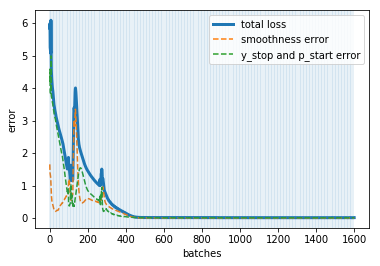

In [10]:
#plot errors after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(smoothness_errors, label = 'smoothness error', linestyle='--')
basic = plt.plot(basic_errors, label = 'y_stop and p_start error', linestyle='--')
plt.legend()
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

In [60]:
print(y_pred.requires_grad)

True


In [11]:
#Save Model
torch.save(model.state_dict(), 'Trained_Models/Trained_Model_050620_400s_200e_onlyZpos_30t.pt')

## Test forward propagation

In [15]:
y_target_test= torch.tensor([0, 2, 0.5])
p = model(y_target_test)
y_pred = Simulate(p)
y_target = y_target_test.detach().numpy()
p = p.detach().numpy()


yTraj_test = dyn.compute(p)

print(yTraj_test.y)
print(np.sum(yTraj_test.y[-3:]-y_target))
print(p)

[ 7.06265214e-05  1.94512096e+00 -2.41065371e-03  3.31315787e-05
  1.92802432e+00 -1.53361098e-03 -2.50241846e-05  1.92932236e+00
  1.56063603e-03 -9.71003644e-05  1.93428661e+00  5.38268862e-03
 -1.62618436e-04  1.93360197e+00  8.86586868e-03 -2.25301555e-04
  1.93395067e+00  1.28316244e-02 -2.85834693e-04  1.93429806e+00
  1.71687823e-02 -3.50448650e-04  1.93525816e+00  2.19732797e-02
 -4.14815980e-04  1.93375367e+00  2.68146188e-02 -4.72172313e-04
  1.93669103e+00  3.27430476e-02 -5.28714245e-04  1.93759710e+00
  3.87745118e-02 -5.78609289e-04  1.93827448e+00  4.51808948e-02
 -6.33160244e-04  1.94006216e+00  5.21617538e-02 -6.88252925e-04
  1.93954718e+00  5.92062964e-02 -7.34688687e-04  1.94146587e+00
  6.70216432e-02 -7.42094754e-04  1.94816654e+00  7.59523267e-02
 -7.49759755e-04  1.95197583e+00  8.48596589e-02 -7.56351785e-04
  1.95427444e+00  9.39290308e-02 -7.62178840e-04  1.95308895e+00
  1.02900194e-01 -7.64573918e-04  1.95149467e+00  1.12150193e-01
 -7.47805104e-04  1.95606

## Torch Script Conversion and Saving

In [12]:
input_example = torch.tensor([0, 2, 0.5])
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
test_input = torch.tensor([0, 2, 0.5])
original = model(test_input)
output_example = traced_script_module(test_input)
print(output_example[-12:])
print(original)

tensor([-3.9022e-04,  2.9629e+00,  2.4275e-01, -7.0935e-04,  2.9643e+00,
         2.3964e-01, -2.0430e-03,  2.9655e+00,  2.4303e-01, -3.5680e-03,
         2.9709e+00,  2.4492e-01], grad_fn=<SliceBackward>)
tensor([-8.6847e-04,  2.9383e+00,  4.3761e-02, -2.1252e-03,  2.9291e+00,
         8.0327e-02, -1.0002e-03,  2.9262e+00,  1.0621e-01, -2.2627e-03,
         2.9286e+00,  1.1861e-01, -2.3899e-03,  2.9266e+00,  1.2396e-01,
         5.2318e-04,  2.9262e+00,  1.4024e-01,  4.9653e-04,  2.9254e+00,
         1.5232e-01, -1.5617e-03,  2.9260e+00,  1.6069e-01,  5.2298e-04,
         2.9239e+00,  1.6690e-01,  4.9579e-04,  2.9262e+00,  1.8283e-01,
         6.3263e-04,  2.9268e+00,  1.8570e-01,  2.0553e-03,  2.9275e+00,
         1.9375e-01, -1.8342e-03,  2.9295e+00,  2.0036e-01, -1.9567e-03,
         2.9284e+00,  2.0832e-01,  9.2597e-04,  2.9311e+00,  2.1489e-01,
         4.4048e-03,  2.9381e+00,  2.2303e-01,  7.9142e-04,  2.9423e+00,
         2.2385e-01,  1.1960e-04,  2.9456e+00,  2.2621e-01, -1.7

In [14]:
# Save serialized model
traced_script_module.save("Serialized_Models/CPP_example_model_latest.pt")